<a href="https://colab.research.google.com/github/astrid12345/recyclo/blob/convert_taco_to_yolo/scripts/convert_taco_dataset_to_yolo_format_multiple_categories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this notebook is to convert a COCO-ish dataset to a format that can be used to train an Ultralytics YOLO model.

# Using this notebook: workflow

To use, make a copy of this notebook, and adapt it to work with your specific dataset. Please save your version of this ipynb file on GitHub in *recyclo/scripts*.

(File > Save a copy in GitHub > File path = "scripts/my_filename.ipynb" to save notebook in scripts folder)

Once you've generated your YOLO dataset, and are confident you can train a model with it, please upload your converted dataset to the Recyclo datasets google drive, https://drive.google.com/drive/folders/1bUkIYQRXX08OKI5TuOSg-eqntSudGaFB.

(Why Google Drive? Because these datasets are too large for GitHub!)

# What's in this notebook: contents

Notebook contents:
- intro to YOLO
- intro to COCO
- dataset specific notes (update for your specific dataset)
- convert dataset to simple COCO (update for your specific dataset)
- convert simple COCO to YOLO

# Pro tips about Colabs

When you open the "Files" tab on the left, you'll find yourself in a folder containing
* ..
* sample data

This is a colab thing, the "content" folder, to get you started.
Ignore it: click the .. to go up a level.

# Intro to YOLO

## General

In general, YOLO models output the following for a given image:
* Bounding box
* Class label
* Confidence score

To train a YOLO model, we need object detection datasets that contain images of what we're looking for (trash), and annotations: class labels and bounding boxes.

## Ultralytics YOLO

In this project we will use Ultralytics YOLO object detection, eg their YOLO11n model. YOLO11n is a pretrained object detection model developed by Ultralytics.

Ultralytics YOLO expects datasets in the following format:

```
dataset/
├── images/
│   ├── train/  <-- image files for training.
│   ├── val/    <-- image files for validation after each epoch. Must not overlap with images in train.
|   └── test/   <-- optional: can put some image files here for benchmarking.
├── labels/
│   ├── train/  <-- one .txt file per train image (must have same name). Contains class and bbox info..
│   ├── val/    <-- one .txt file per val image.
|   └── test/   <-- one .txt file per test image.
└── data.yaml   <-- config file; helps tie all the above together.
```

Example labels/train file:
```
<class_id> <x_center> <y_center> <width> <height>
```

Example data.yaml file:
```
path: /content/dataset  # Root folder
train: images/train
val: images/val

nc: 5  # number of classes
names: ['bottle', 'can', 'plastic bag', 'wrapper', 'paper']

```

# Intro to COCO

## General
COCO, Common Objects in Context, is a object detection, segmentation, and captioning dataset developed by Microsoft. It uses an annotations.json file to organize image data. This json annotation approach has become standard for other datasets to use.

Lots of datasets use COCO-style of formatting. In addition to the training images themselves, these datasets have at least one annotations json file which contains the following:
*   "images":  List of image metadata
*   "annotations":  List of label data (type of trash, bounding box definition, segmentation data; corresponds to images list)
*   "categories":  List of the different categories this dataset uses

An example of a COCO-style dataset file structure is as follows:
```
dataset/
├── annotations/
│   ├── instances_train2017.json
│   ├── instances_val2017.json
│   ├── person_keypoints_train2017.json
│   ├── captions_train2017.json
│   └── ... (other task-specific .json files)
├── images/
│   ├── train2017/
│   │   ├── 000000000009.jpg
│   │   ├── 000000000025.jpg
│   │   └── ...
│   └── val2017/
│       ├── 000000000139.jpg
│       ├── 000000000285.jpg
│       └── ...
└── LICENSE.txt (optional)
```

## Simple COCO format required by the COCO-to-YOLO conversion function


To use the COCO to YOLO conversion function below, your data set must conform to the following (vastly simplified) COCO-like directory structure and json structure. It's unlikely that your dataset will conform to these specifications out of the box, so please use the code section below to modify your data's structure to match.

The simple COCO directory structure must be as follows, with a folder called "dataset" located in your "content" directory:
```
dataset/
├── images/
│   ├── 000001.jpg  # or png or whatever
│   ├── 000002.jpg
│   └── ...
└── annotations.json
```

And the annotations.json file must contain information in the following structure, and using the following json keywords:
```
{
  "images": [
    {
      "id": 1,
      "file_name": "000001.jpg",
      "width": 640,
      "height": 480
    },
    {
      "id": 2,
      "file_name": "000002.jpg",
      "width": 800,
      "height": 600
    }
  ],
  "annotations": [
    {
      "id": 1,
      "image_id": 1,
      "category_id": 1,
      "bbox": [100, 120, 50, 60],
      "area": 3000,
      "iscrowd": 0
    },
    {
      "id": 2,
      "image_id": 2,
      "category_id": 2,
      "bbox": [20, 30, 40, 50],
      "area": 2000,
      "iscrowd": 0
    }
  ],
  "categories": [
    {
      "id": 1,
      "name": "plastic"
    },
    {
      "id": 2,
      "name": "metal"
    }
  ]
}
```


# Helpful functions

This section has some helpful functions you can use later in this notebook.

In [2]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell sets up a helpful function for inspecting json file contents

import json
from pprint import pprint

def show_first_two_per_category(json_path):
    """
    Prints the first two entries of each root-level list in a JSON file.

    Useful for quickly inspecting the structure and content of a COCO-style
    annotations json file.

    It pretty-prints the first two entries of each top-level key that contains a list.

    Args:
        json_path (str or Path): Path to the JSON file to inspect.

    Raises:
        FileNotFoundError: If the provided path does not point to an existing file.
        json.JSONDecodeError: If the file is not valid JSON.
    """
    json_path = Path(json_path)

    if not json_path.exists():
        print(f"File not found: {json_path}")
        return

    with open(json_path, 'r') as f:
        data = json.load(f)

    for key, value in data.items():
        print(f"\n--- {key.upper()} (showing first 2 entries) ---")
        if isinstance(value, list):
            for item in value[:2]:
                pprint(item)
        else:
            print(f"{key} is not a list, skipping.")


---
⚠️‼️ ***THE SECTION TO CHANGE FOR YOUR SPECIFIC DATASET STARTS HERE*** ‼️⚠️

The sections above apply for all dataset conversions.

---

In [3]:
# ✏️ Enter your dataset-specific code here
# This cell is for importing your dataset to the notebook, and defining its name and path.

# TACO: Sometimes you have to wait a while or run this twice for it to show up in the file tree
import kagglehub
from pathlib import Path

dataset_name = "TACO"
taco_dataset_path = Path(kagglehub.dataset_download('kneroma/tacotrashdataset'))  # https://www.kaggle.com/datasets/kneroma/tacotrashdataset

print(f"{dataset_name} dataset downloaded to {taco_dataset_path}\n")

100%|██████████| 2.79G/2.79G [00:23<00:00, 128MB/s]

Extracting files...


TACO dataset downloaded to /root/.cache/kagglehub/datasets/kneroma/tacotrashdataset/versions/3



In [4]:
# ✏️ Enter your dataset-specific code here
# This cell is for inspecting your annotations json file(s), to help discover some of the quirks your dataset has

show_first_two_per_category(taco_dataset_path / "data" / "annotations.json")


--- INFO (showing first 2 entries) ---
info is not a list, skipping.

--- IMAGES (showing first 2 entries) ---
{'coco_url': None,
 'date_captured': None,
 'file_name': 'batch_1/000006.jpg',
 'flickr_640_url': 'https://farm66.staticflickr.com/65535/33978196618_632623b4fc_z.jpg',
 'flickr_url': 'https://farm66.staticflickr.com/65535/33978196618_e30a59e0a8_o.png',
 'height': 2049,
 'id': 0,
 'license': None,
 'width': 1537}
{'coco_url': None,
 'date_captured': None,
 'file_name': 'batch_1/000008.jpg',
 'flickr_640_url': 'https://farm66.staticflickr.com/65535/47803331152_19beae025a_z.jpg',
 'flickr_url': 'https://farm66.staticflickr.com/65535/47803331152_ee00755a2e_o.png',
 'height': 2049,
 'id': 1,
 'license': None,
 'width': 1537}

--- ANNOTATIONS (showing first 2 entries) ---
{'area': 403954.0,
 'bbox': [517.0, 127.0, 447.0, 1322.0],
 'category_id': 6,
 'id': 1,
 'image_id': 0,
 'iscrowd': 0,
 'segmentation': [[561.0,
                   1238.0,
                   568.0,
               

# TACO dataset
✏️ Modify this section for your specific dataset.

The TACO dataset uses COCO-style formatting (it has segmentation).

## Quirks

TACO has 15 batch folders, each containing jpgs with names like 000000.jpg, 000001.jpg, 000002.jpg, etc.
* Some numbers are skipped, eg 000000.jpg, 000001.jpg, 000003.jpg.
* The name 000000.jpg is used in multiple batch folders, to name different image files.
* It contains segmentation data (will be discarded).
* It uses categories (specific) and supercategories (more general) - only the supercategories will be retained.
* It includes scene categories (eg clearn streets) - this will be discarded.
  * It might be interesting in the future to consider using a multi-tasking model - detecting trash and also classsifying the scene might improve the models performance by adding a bit of context awareness.

## Conversion
To convert the TACO dataset to a format ultralytics YOLO can use, we must:
* Give the images unique names
* Split the TACO images into train and val sets
* Extract label and bbox info from annotations.json, and save it in individual txt files corresponding to the image files
* Make a data.yaml file

In [5]:
# ✏️ Enter your dataset-specific code here
# This cell is for modifying your dataset structure to match the required simple COCO style

import shutil

source_root = taco_dataset_path / "data"
annotations_path = source_root / 'annotations.json'

target_root = Path('/content/dataset')
target_img_dir = target_root / 'images'
if target_root.exists():
    shutil.rmtree(target_root)
target_img_dir.mkdir(parents=True, exist_ok=True)

with annotations_path.open('r') as f:
    annotations = json.load(f)

# Reassign file names with unique zero-padded numbering
image_id_map = {}
for idx, image_info in enumerate(annotations['images']):
    old_path = source_root / image_info['file_name']
    new_filename = f"{idx:06}.jpg"
    new_path = target_img_dir / new_filename

    image_id_map[old_path] = new_path
    image_info['file_name'] = new_filename

    # Keep only required image fields
    annotations['images'][idx] = {
        'id': image_info['id'],
        'file_name': new_filename,
        'width': image_info['width'],
        'height': image_info['height']
    }

# Prune annotation fields
for ann in annotations['annotations']:
    ann_keys = ['id', 'image_id', 'category_id', 'bbox', 'area', 'iscrowd']
    for key in list(ann.keys()):
        if key not in ann_keys:
            del ann[key]

# Update category entries to only include id and name = supercategory
for cat in annotations['categories']:
    cat_keys = ['id', 'name']
    for key in list(cat.keys()):
        if key not in cat_keys:
            del cat[key]

# Copy image files to new location
for src, dst in image_id_map.items():
    if src.exists():
        shutil.copy(src, dst)
    else:
        print(f"Warning: Missing image: {src}")

# Remove unwanted top-level keys
for key in ['info', 'scene_annotations', 'scene_categories', 'licenses']:
    annotations.pop(key, None)

# Save cleaned annotations
new_annotations_path = target_root / 'annotations.json'
with new_annotations_path.open('w') as f:
    json.dump(annotations, f)

print(f"Converted and cleaned {len(image_id_map)} images.")

Converted and cleaned 1500 images.



---
⚠️‼️ ***THE SECTION TO CHANGE FOR YOUR SPECIFIC DATASET STOPS HERE*** ‼️⚠️

The sections below apply for all dataset conversions.

---

In [6]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell shows part of your annotations.json file to make sure the format and field names match the required simple COCO format

show_first_two_per_category(target_root / "annotations.json")


--- IMAGES (showing first 2 entries) ---
{'file_name': '000000.jpg', 'height': 2049, 'id': 0, 'width': 1537}
{'file_name': '000001.jpg', 'height': 2049, 'id': 1, 'width': 1537}

--- ANNOTATIONS (showing first 2 entries) ---
{'area': 403954.0,
 'bbox': [517.0, 127.0, 447.0, 1322.0],
 'category_id': 6,
 'id': 1,
 'image_id': 0,
 'iscrowd': 0}
{'area': 1071259.5,
 'bbox': [1.0, 457.0, 1429.0, 1519.0],
 'category_id': 18,
 'id': 2,
 'image_id': 1,
 'iscrowd': 0}

--- CATEGORIES (showing first 2 entries) ---
{'id': 0, 'name': 'Aluminium foil'}
{'id': 1, 'name': 'Battery'}


In [7]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell sets up the function that converts the simple COCO dataset to YOLO format

import shutil
import random
import yaml
from collections import defaultdict

def convert_coco_to_yolo(coco_root: Path, dataset_name: str, train_split: float = 0.8):
    """
    Converts a simple COCO dataset to YOLOv8 format, including train/val split and data.yaml generation.

    Args:
        coco_root (Path): Path to the root of the simple COCO dataset (should contain images/ and annotations.json).
        dataset_name (str): Name of the output dataset folder (e.g., "taco" -> creates "taco_yolo").
        train_split (float, optional): Fraction of images to use for training. Defaults to 0.8.
          The remaining images are split between validation and testing.

    Returns:
        Path: Path to the data.yaml file
    """
    # Paths
    coco_json_path = coco_root / 'annotations.json'
    coco_images_path = coco_root / 'images'

    # Load COCO JSON and get number of images for naming
    with open(coco_json_path, 'r') as f:
        coco = json.load(f)
    n_total = len(coco['images'])

    # Paths con't
    yolo_root = coco_root.parent / f"{dataset_name}_yolo_{n_total}"
    yolo_img_dirs = {
        'train': yolo_root / 'images' / 'train',
        'val': yolo_root / 'images' / 'val',
        'test': yolo_root / 'images' / 'test',
    }
    yolo_lbl_dirs = {
        'train': yolo_root / 'labels' / 'train',
        'val': yolo_root / 'labels' / 'val',
        'test': yolo_root / 'labels' / 'test',
    }

    # Clear and recreate folders
    for d in list(yolo_img_dirs.values()) + list(yolo_lbl_dirs.values()):
        if d.exists():
            shutil.rmtree(d)
        d.mkdir(parents=True, exist_ok=True)

    # Map image_id -> metadata
    image_info = {img['id']: (img['width'], img['height'], img['file_name']) for img in coco['images']}

    # Map image_id -> annotations
    annots_per_image = defaultdict(list)
    for ann in coco['annotations']:
        annots_per_image[ann['image_id']].append(ann)

    # Shuffle and split image IDs
    all_image_ids = list(image_info.keys())
    random.shuffle(all_image_ids)
    n_total = len(all_image_ids)
    n_train = int(n_total * train_split)
    n_val = int((n_total - n_train) / 2)
    n_test = n_total - n_train - n_val

    split_ids = {
        'train': set(all_image_ids[:n_train]),
        'val': set(all_image_ids[n_train:n_train + n_val]),
        'test': set(all_image_ids[n_train + n_val:]),
    }

    def write_labels_and_copy_images(image_ids, img_dir, lbl_dir):
        for image_id in image_ids:
            width, height, filename = image_info[image_id]
            orig_stem = Path(filename).stem
            new_stem = f"{dataset_name}_{orig_stem}"
            label_path = lbl_dir / f"{new_stem}.txt"
            image_src = coco_images_path / filename
            image_dst = img_dir / f"{new_stem}.jpg"

            # Copy image
            if image_src.exists():
                shutil.copy(image_src, image_dst)
            else:
                print(f"Warning: Image not found: {image_src}")
                continue

            # Write labels
            with open(label_path, 'w') as f:
                for ann in annots_per_image.get(image_id, []):
                    class_id = ann['category_id']
                    x, y, w, h = ann['bbox']
                    x_center = (x + w / 2) / width
                    y_center = (y + h / 2) / height
                    w /= width
                    h /= height
                    f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {w:.6f} {h:.6f}\n")

    # Process splits
    for split in ['train', 'val', 'test']:
        write_labels_and_copy_images(
            split_ids[split],
            yolo_img_dirs[split],
            yolo_lbl_dirs[split]
        )

    # Build data.yaml
    categories = sorted(coco['categories'], key=lambda x: x['id'])
    names = [cat['name'] for cat in categories]
    data_yaml = {
        'path': str(yolo_root),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        'nc': len(names),
        'names': names
    }

    with open(yolo_root / 'data.yaml', 'w') as f:
        yaml.dump(data_yaml, f)

    print(f"YOLO conversion complete: {yolo_root}")
    print(f"  Train: {len(split_ids['train'])}, Val: {len(split_ids['val'])}, Test: {len(split_ids['test'])}")
    return yolo_root / 'data.yaml'

In [8]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell executes the simple COCO dataset to YOLO conversion

yolo_data = convert_coco_to_yolo(target_root, dataset_name)

YOLO conversion complete: /content/TACO_yolo_1500
  Train: 1200, Val: 150, Test: 150


To verify that your conversion worked, make sure you can train a model and that it outputs images with a bounding box and label.

In [9]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell imports the ultralytics library required for training a model

!pip install -U ultralytics

from ultralytics import YOLO
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [10]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell trains a YOLO model on the converted YOLO dataset to see if it's set up correctly
# Tip: inspect the output of this cell to assess whether training occured properly.

model = YOLO('yolo11n.pt')
results = model.train(data=str(yolo_data), epochs=4, imgsz=640)  # epoch size is small - this is just to see if it can work!

100%|██████████| 5.35M/5.35M [00:00<00:00, 69.3MB/s]


Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/TACO_yolo_1500/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=4, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretra

100%|██████████| 755k/755k [00:00<00:00, 23.6MB/s]

Overriding model.yaml nc=80 with nc=60

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytic

 23        [16, 19, 22]  1    442372  ultralytics.nn.modules.head.Detect           [60, [64, 128, 256]]          
YOLO11n summary: 181 layers, 2,601,540 parameters, 2,601,524 gradients, 6.5 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 147.9±20.6 MB/s, size: 1001.3 KB)


train: Scanning /content/TACO_yolo_1500/labels/train... 1200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1200/1200 [00:03<00:00, 376.97it/s]

train: New cache created: /content/TACO_yolo_1500/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 121.2±37.3 MB/s, size: 1551.6 KB)


val: Scanning /content/TACO_yolo_1500/labels/val... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<00:00, 258.35it/s]

val: New cache created: /content/TACO_yolo_1500/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000156, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 4 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/4      2.75G      1.225      5.368      1.182         58        640: 100%|██████████| 75/75 [01:20<00:00,  1.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.11s/it]

                   all        150        480          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/4      2.93G      1.186      5.025      1.122        116        640: 100%|██████████| 75/75 [01:16<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.13s/it]

                   all        150        480     0.0152      0.313      0.031     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/4      2.94G      1.203      4.787      1.135         65        640: 100%|██████████| 75/75 [01:15<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]

                   all        150        480      0.265      0.116      0.039     0.0335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/4      2.96G       1.21      4.597      1.138         60        640: 100%|██████████| 75/75 [01:16<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.26it/s]

                   all        150        480      0.314     0.0818     0.0368     0.0306



4 epochs completed in 0.093 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.148 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,593,852 parameters, 0 gradients, 6.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:10<00:00,  2.10s/it]


                   all        150        480      0.265      0.116     0.0391     0.0335
        Aluminium foil          3          8          0          0     0.0363     0.0307
               Battery          1          1          0          0          0          0
Aluminium blister pack          1          1          1          0          0          0
  Other plastic bottle          5          5     0.0545        0.6     0.0567     0.0425
  Clear plastic bottle         21         23      0.143      0.304      0.124     0.0872
          Glass bottle          8         11     0.0258     0.0909     0.0445      0.031
    Plastic bottle cap         25         26          1          0     0.0172      0.016
      Metal bottle cap          7          7     0.0215      0.143     0.0262      0.025
          Broken glass          2          2          1          0          0          0
              Food Can          2          4        0.1          1      0.638      0.615
             Drink ca

If the model outputs even one image with a bounding box and label, then the dataset should work for our project! Verify this using the code below.

Loading runs/detect/train/weights/best.pt

image 1/1 /content/TACO_yolo_1500/images/train/TACO_000486.jpg: 640x480 (no detections), 72.2ms
Speed: 4.9ms preprocess, 72.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 480)


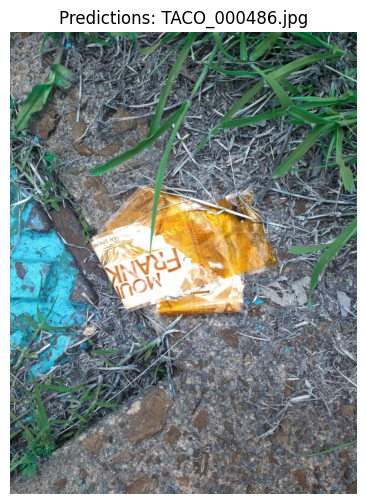


image 1/1 /content/TACO_yolo_1500/images/train/TACO_001135.jpg: 640x480 (no detections), 21.8ms
Speed: 12.8ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


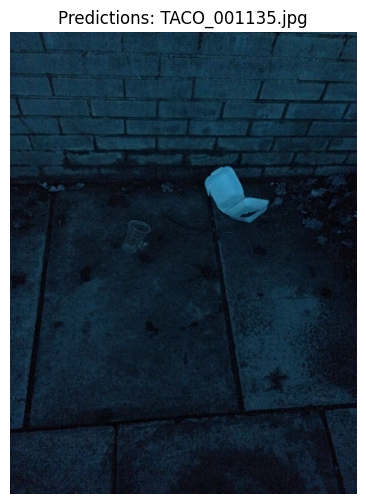


image 1/1 /content/TACO_yolo_1500/images/train/TACO_000871.jpg: 480x640 (no detections), 193.7ms
Speed: 8.1ms preprocess, 193.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


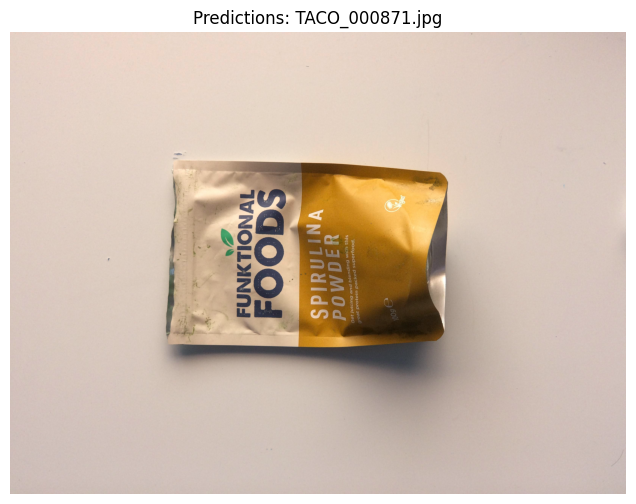


image 1/1 /content/TACO_yolo_1500/images/train/TACO_000654.jpg: 640x480 (no detections), 16.1ms
Speed: 4.7ms preprocess, 16.1ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 480)


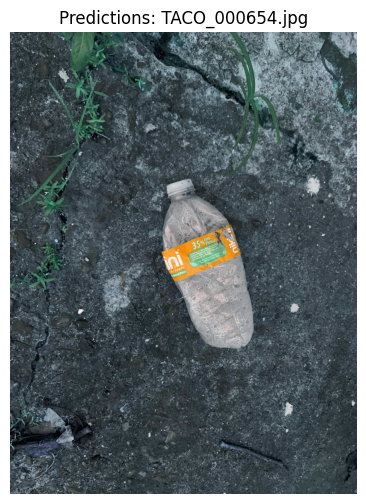


image 1/1 /content/TACO_yolo_1500/images/train/TACO_000809.jpg: 640x480 (no detections), 15.6ms
Speed: 4.7ms preprocess, 15.6ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


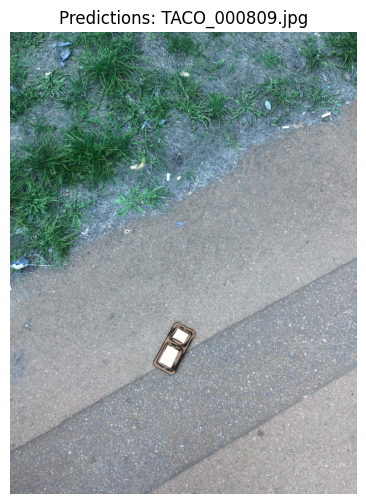


image 1/1 /content/TACO_yolo_1500/images/train/TACO_001293.jpg: 480x640 (no detections), 87.4ms
Speed: 6.6ms preprocess, 87.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


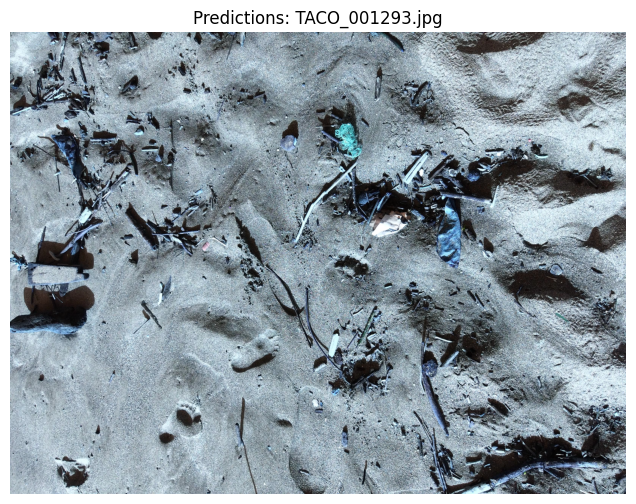


image 1/1 /content/TACO_yolo_1500/images/train/TACO_000998.jpg: 640x480 1 Plastic lid, 1 Plastic film, 1 Other plastic wrapper, 17.6ms
Speed: 4.4ms preprocess, 17.6ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


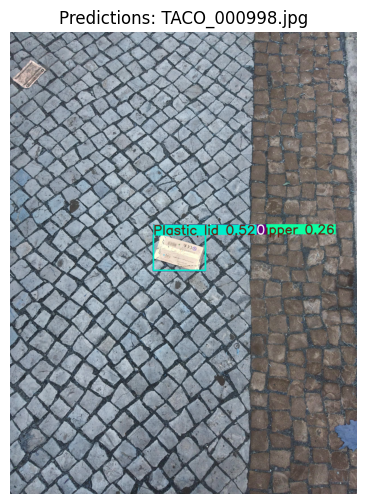


image 1/1 /content/TACO_yolo_1500/images/train/TACO_001233.jpg: 480x640 (no detections), 13.2ms
Speed: 5.1ms preprocess, 13.2ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


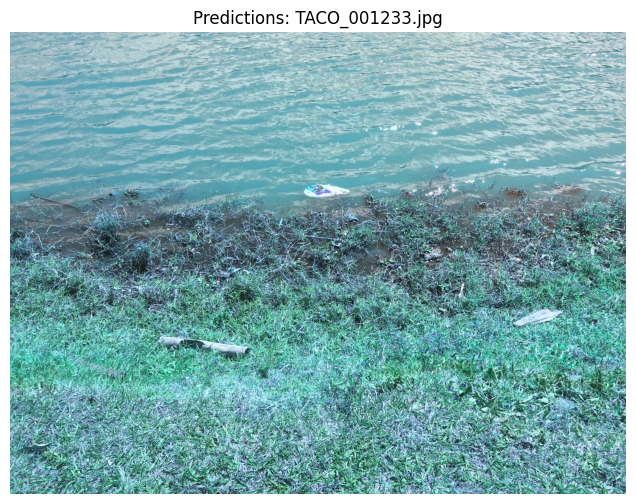


image 1/1 /content/TACO_yolo_1500/images/train/TACO_000807.jpg: 640x480 (no detections), 13.2ms
Speed: 4.7ms preprocess, 13.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 480)


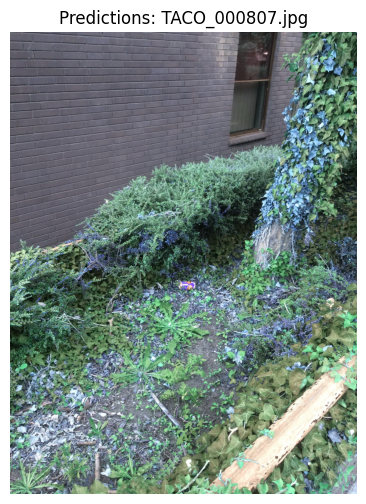


image 1/1 /content/TACO_yolo_1500/images/train/TACO_000069.jpg: 480x640 (no detections), 13.2ms
Speed: 4.4ms preprocess, 13.2ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)


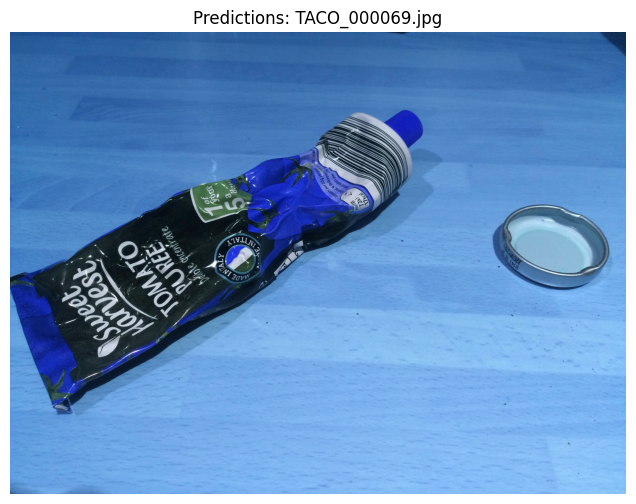

In [11]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell passes the trained model some images, to see if the model can identify some trash

import cv2
from random import sample
import matplotlib.pyplot as plt

# Get the latest model
runs_detect_dir = Path('runs/detect')
train_dirs = [d for d in runs_detect_dir.iterdir() if d.is_dir() and d.name.startswith("train")]
train_dirs.sort(key=lambda d: d.stat().st_mtime, reverse=True)  # sort by modification time
latest_train_dir = train_dirs[0]
best_model_path = latest_train_dir / 'weights' / 'best.pt'
print(f"Loading {best_model_path}")

# Load the model and try it out
model = YOLO(best_model_path)
train_images_path = yolo_data.parent / "images" / "train"
image_files = list(train_images_path.glob('*.jpg'))

sample_images = sample(image_files, 10)

for image_path in sample_images:
    result = model(image_path)[0]
    annotated_image = result.plot()

    plt.figure(figsize=(8, 6))
    plt.imshow(annotated_image)
    plt.title(f'Predictions: {image_path.name}')
    plt.axis('off')
    plt.show()

If the model successfully generated even one image with a bounding box and label, please run the following code block to zip the taco_yolo dataset, download the zipped file, and upload it on Google Drive, https://www.google.com/url?q=https%3A%2F%2Fdrive.google.com%2Fdrive%2Ffolders%2F1bUkIYQRXX08OKI5TuOSg-eqntSudGaFB.

In [12]:
# ⚠️ DO NOT MODIFY THIS CELL
# This cell zips your converted YOLO dataset with an informative name, so you can download it and upload it to google drive.

from datetime import datetime

# Generate date prefix
date_str = datetime.now().strftime('%Y%m%d')
zip_name = f"{date_str}_{yolo_data.parent.stem}.zip"

# Change directory and zip
%cd {yolo_data.parent}
!zip -r /content/{zip_name} .

print(f"Zip created at /content/{zip_name}")

/content/TACO_yolo_1500
  adding: images/ (stored 0%)
  adding: images/val/ (stored 0%)
  adding: images/val/TACO_000192.jpg (deflated 0%)
  adding: images/val/TACO_001015.jpg (deflated 0%)
  adding: images/val/TACO_000401.jpg (deflated 0%)
  adding: images/val/TACO_000003.jpg (deflated 0%)
  adding: images/val/TACO_001257.jpg (deflated 0%)
  adding: images/val/TACO_000333.jpg (deflated 0%)
  adding: images/val/TACO_000625.jpg (deflated 0%)
  adding: images/val/TACO_000961.jpg (deflated 0%)
  adding: images/val/TACO_001362.jpg (deflated 0%)
  adding: images/val/TACO_000683.jpg (deflated 0%)
  adding: images/val/TACO_000931.jpg (deflated 0%)
  adding: images/val/TACO_001162.jpg (deflated 0%)
  adding: images/val/TACO_000989.jpg (deflated 0%)
  adding: images/val/TACO_001392.jpg (deflated 0%)
  adding: images/val/TACO_000915.jpg (deflated 0%)
  adding: images/val/TACO_000295.jpg (deflated 0%)
  adding: images/val/TACO_000861.jpg (deflated 0%)
  adding: images/val/TACO_000750.jpg (deflate